# About
This document aims to explain the crossover detection pipeline from the raw samples to the visual output.

## Pipeline Prerequisites  
- [BWA](http://bio-bwa.sourceforge.net/bwa.shtml#3)
- [samtools](http://www.htslib.org/doc/samtools.1.html)
- [Picard](https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.4.0)
- [bedtools](https://bedtools.readthedocs.io/en/latest)
- [Python 3.7+](https://www.python.org) with:
    - pandas
    - matplotlib
    - [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/)

# Coda Workflow
The core hypothesis of coda relies on alignment to dual genome.  

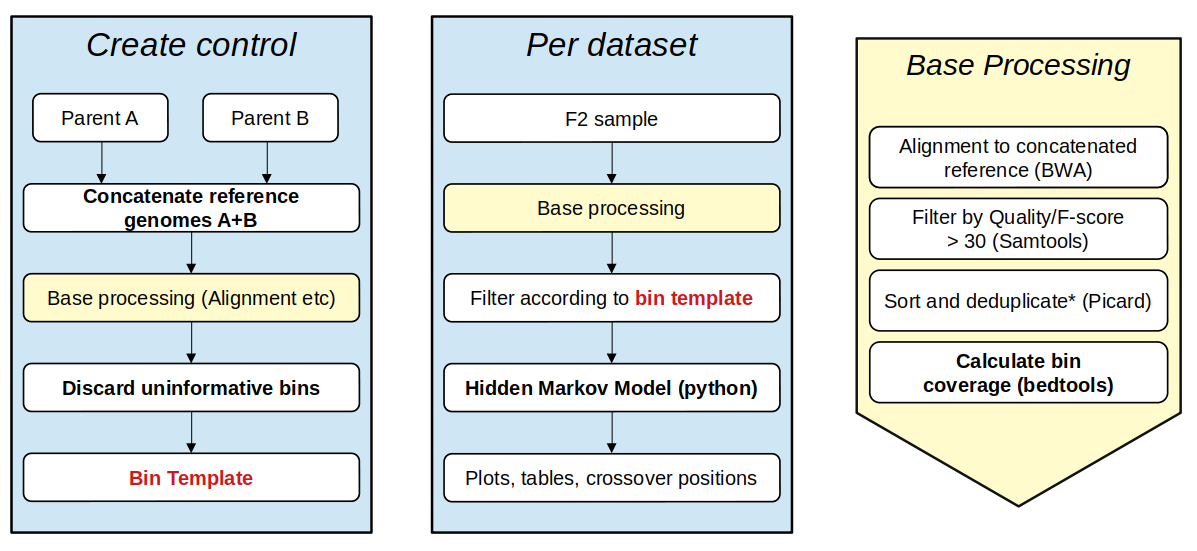

## Assembling the reference
1. **Change fasta file headers.** Determines the chromosome notation used downstream. Use distinct, alphabetical names. *Do not* use digits.
```bash
 awk '/^>/{print ">alpha" ++i; next}{print}' < genomeA.fasta
 awk '/^>/{print ">beta" ++i; next}{print}' < genomeB.fasta
 ```
2. **Concatenate reference files.** This is the reference all samples are mapped to.
```bash
cat genomeA.fasta genomeB.fasta > genomeAB.fasta
```
3. **Generate genome sizes.** Used to generate bins. View `genomeAB_sizes.txt` afterwards to verify the genome names and sizes.
```bash
# module load samtools-gnu 
samtools faidx genomeAB.fasta
cut -f1,2 genomeAB.fasta.fai > genomeAB_sizes.txt # notice input is .fai here
```
4. **Index concatenated reference.** Required for BWA alignment.
```bash
# module load bwa-gnu
bwa index genomeAB.fasta
```

## Create bin template
5. **Map source alignments and filter.** Using `BWA mem`, map each pair of reads `genomeA_R1_00N.fastq.gz`, `genomeB_R2_00N.fastq.gz` to `genomeAB.fasta` (`-t 5` is the amount of parallel threads, it does not alter the alignment result). Pipe the output to samtools in order to filter out reads with quality / Fred score < 30 and convert to BAM format (binary / smaller form of SAM).
```bash
# module load bwa-gnu samtools-gnu
for R1 in genomeA_control_L001_00*R1.fastq.gz; 
do
    bwa mem -t 5 references/genomeAB.fasta $R1 $R2 | samtools view -Sbh -q 30 - > genomeA_control_00N.bam
done
```
4. **Merge and sort** all alignment files of the same library.
```bash
samtools merge genomeA_control_001.bam genomeA_control_002.bam  [...] > genomeA_control_merged.bam
samtools sort genomeA_control_merged.bam > genomeA_control_merged.sorted.bam
```
6. **Deduplicate** in order to retain unique reads
```bash
# module load jdk picard
picard MarkDuplicates I=genomeA_control_merged.sorted.bam O=genomeA_control_merged.sorted.dedup.bam M=genomeA_control_merged.dedup_metrics.txt REMOVE_DUPLICATES=true
```
7. **Create bins table** (decide on bin size, step size) using `make_bins.py` (previewed below)
```bash
python make_bins.py genomeAB_sizes.txt 200
```
8. **Calcuate control coverage** to see where each parent aligns
```bash
bedtools coverage -counts -sorted -a genomeAB_sizes.bins.txt -b genomeA_control_merged.sorted.dedup.bam > genomeA_control.cov-sizes.bedgraph
```
8. **Filter uninformative bins** with `filter_genomes.py`. This results in reads that aren't unique to either parent to be thrown out, resulting in a much cleaner template.
```bash
python filter_genomes.py genomeA_control.cov-sizes.bedgraph genomeB_control.cov-sizes.bedgraph genomeAB_template.cov-sizes.bedgraph
```
9. **Optional: Calculate average bin coverage**.
```bash
cat genomeA_control.cov-sizes.bedgraph | awk '{sum+=$4} END { print "Average = ",sum/NR}'
```


In [ ]:
# %load scripts/make_bins.py
import argparse
import pandas as pd

parser = argparse.ArgumentParser(description='Splits the genome into equal sized bins to be used with bedtools.')
parser.add_argument('reference', type=str, help='Reference genome sizes file.')
parser.add_argument('binSize', type=int, help='Size of each bin.')
parser.add_argument('binStep', type=int, default=0, nargs='?',
    help='Step size between bins. Defaults to bin size.')
args = parser.parse_args()
if args.binStep == 0:
    args.binStep = args.binSize

genome_sizes = pd.read_csv(args.reference, sep='\t', index_col=0, names=['chrm', 'size'])
chrm_bins_df = []

print(f'Creating bins for "{args.reference}" with binSize={args.binSize} and binStep={args.binStep}.')

# iterate over chromosomes
for chrm, row in genome_sizes.iterrows():
    start = pd.np.arange(1, row['size'], args.binStep)
    end = start + args.binSize
    name = pd.np.full(len(start), chrm)
    # shape positions as dataframe
    data = {'chr': name, 'start': start, 'end': end}
    df = pd.DataFrame(data)
    chrm_bins_df.append(df)

bin_table = pd.concat(chrm_bins_df)
if args.binStep == args.binSize:
    name_out = f'{args.reference}.bins-{args.binSize}.txt'
else:
    name_out = f'{args.reference}.bins-{args.binSize}-{args.binStep}.txt'
try:
    bin_table.to_csv(name_out, sep='\t', index=False)
    print(f'Done. Bin table written to "{name_out}".')
except Exception as ex:
    print(f'Failed to write results to "{name_out}". Please check the directory exists and has suitable permissions.\n{ex}')

In [ ]:
# %load scripts/filter_genomes.py
import argparse
import pandas as pd

parser = argparse.ArgumentParser(description='Creates an informative bin template based on coverage A and B as produced by bedtools.')
parser.add_argument('covA', type=str, help='Coverage bedgraph of control parent A.')
parser.add_argument('covB', type=str, help='Coverage bedgraph of control parent B.')
parser.add_argument('out', type=str, help='Filename to output the resulting template to.')
args = parser.parse_args()


print(f'Creating bin template using "{args.covA}" and "{args.covB}".')

genome_a = pd.read_csv(args.covA, sep='\t', names=['chrm', 'start', 'end', 'val'])
genome_b = pd.read_csv(args.covB, sep='\t', names=['chrm', 'start', 'end', 'val'])

genome_names = genome_a.chrm.str.replace(r'\d', '', regex=True).unique()
# Make sure the names are in the correct order
if genome_a[genome_a['chrm'].str.startswith(genome_names[0])].val.mean() < genome_a[~genome_a['chrm'].str.startswith(genome_names[0])].val.mean():
    genome_names = genome_names[::-1]

genome_reads = genome_a.merge(genome_b, on=['chrm','start','end'], suffixes=(genome_names[0], genome_names[1]))

length = genome_reads.iloc[0, 2] - genome_reads.iloc[0, 1]
step = genome_reads.iloc[1, 1] - genome_reads.iloc[0, 1]

for s in genome_names:
    source_bins = genome_reads.index[genome_reads.chrm.str.startswith(s)]
    informative_map = genome_reads.loc[source_bins, 'val' + s] != 0
    unique_map = genome_reads.loc[source_bins, 'val' + s] == genome_reads.iloc[source_bins, 3:].sum(axis=1)
    genome_reads.loc[source_bins, 'keep'] = informative_map & unique_map

keep = genome_reads.keep.sum() * 100 / genome_reads.keep.count()
print('{0:.2f}% bins kept past filtering.'.format(keep))

genome_template = genome_reads[genome_reads.keep].iloc[:, :3]

try:
    genome_template.to_csv(args.outFile, sep='\t', index=False, header=False)
    print(f'Done. Template written to "{args.out}".')
except Exception as ex:
    print(f'Failed to write results to "{args.out}". Please check the directory exists and has suitable permissions.\n{ex}')


## Prepare individual dataset
Sample level steps can be mass deployed using the script `processing_pipeline.sh` (previewed below) and `dirs_process.sh`.  
The script expects as an input the R1 fastq file of a reads pair.  
All of the commands are the same as processing the control samples, except for the last step: when calculating coverage, use the template `genomeAB_template.cov-sizes.bedgraph` generated from `filter_genome.py` in step 2.2.9 instead of `genomeAB_sizes.bins.txt`.

1. Map sample reads to concatenated reference `genomeAB.fasta`
2. Quality filter and sort
3. Remove duplicates
4. Get coverage over bin template using bedtools

In [ ]:
#%load scripts/coda_pipeline.sh
#!/bin/bash

# -------Set-Constants--------------------------

# Concatenated genome reference
# Remember to run bwa index on the index beforehand
REF="collab/references/mergedAB.fasta"

# Informative bin template created by filter_genomes.py
TEMPLATE="collab/references/mergedAB.cov-200.bedgraph"

# -------Alignment and Filtering----------------

# Input: First of paired illumina reads (.fastq)
# Output: Sorted and filtered bedgraph with coverage data

# Only relevant to HPC module supported systems
module load bwa-gnu         # http://bio-bwa.sourceforge.net/bwa.shtml#3
module load samtools        # http://www.htslib.org/doc/samtools.1.html
module load jdk             # Java, required to run Picard
module load picard          # https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.4.0/picard_sam_markduplicates_MarkDuplicates.php
module load bedtools-gnu    # https://bedtools.readthedocs.io/en/latest/content/tools/coverage.html

# $1 is command line arg fastq, get R2 file by replacing pair symbol
R2="${1/_1/_2}"
# Get sample name by stripping pair symbol and file extension
sample="${1/_1/}"
fname="${sample%%.*}"

# Perform alignment, pipe directly to samtools in order to reduce storage reqs
# Convert to BAM, filter by Q> 30 and unmapped / non-primary / PCR / alignments
# Sort and output to fname
bwa mem -t 5 $ref $1 $R2 | samtools view -Sbh -F 1284 -q 30 - | samtools sort - -o "$fname".q30.sorted.bam

# Remove duplicates
picard MarkDuplicates I="$fname".q30.sorted.bam O="$fname".dedup.q30.sorted.bam M="$fname".dup_metrics.txt REMOVE_DUPLICATES=true

# Extract template extension
extname="${TEMPLATE##*.}"
# Get coverage count according to template
bedtools coverage -counts -sorted -a "$TEMPLATE" -b "$fname".dedup.q30.sorted.bam > "$fname".dedup.q30.sorted."$extname"


# ----------------------------

# Run coda

module load anaconda
source "$CONDA_PREFIX"/bin/activate xoe
python -m coda "$fname".dedup.cov-200-200.bedgraph


## Analysis with module
There are multiple python dependencies required in order for `coda.py` to run. The recommended way to set up a suitable environment is by using [Anaconda3](https://www.anaconda.com/distribution/).
```bash
module load anaconda # for servers that use "module" imports such as wexac
conda env create -f hmm_env.yml # creates a virtual environment with specified requirements
conda activate xoe # activate it
python -m my_sample.dedup.cov.bedgraph predict # running the default pipeline on file "my_sample"
```
For advanced users who would rather use their own environments, the dependencies are listed below. Later versions of the packages are likely to work, but were not tested.
```
  - python=3.7.*                                   
  - pandas=0.24.*
  - matplotlib
  - hmmlearn
```
- Works well indepedant of coverage (avg < 1) ERR2377152

## Training a model

# Module Documentation

`CrossoverDetector`: represents a single F2 sample to be processed.  
By using the command line utility


`HMM`: hidden markov model of type GaussianHMM imported from hmmlearn. When predicting CO positions it's recommended to use a previously trained model. Alternatively, a model can be trained from scratch.  
`crossovers`: matching reciprocal crossovers based on relative position in chromosome.  
**todo: add precise desc**  
`flags`: dictionary, contains the state of other processes.

## transform_data() - Aggregating Read Count
Two methods: `arbitrary` or `robust`, which use `group_count` or `bin_size` respectively.
`Arbitrary` is used by default.  
Plotted below is an example of the sample data processed by the different methods.

**Arbitrary - aggregate every `group_count` points.**
* Consistent distribution across samples
* Less bins
* Clear Heterozygote 0 group
* Better results overall

**Robust - all points in each `bin_size` section are grouped**
* Distribution highly affected by coverage
* More bins
* Bins contain very few datapoints
* Better defined aggregation

(todo - add illustration)

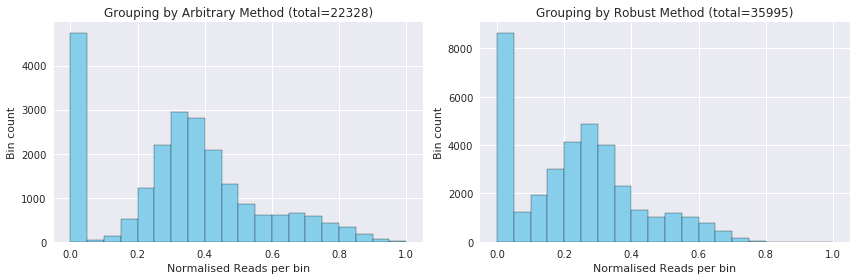

In [5]:
fig = plt.figure(figsize=(12,4))

for i, method in enumerate(['arbitrary', 'robust']):
    s = coda.CrossoverDetector(log_level=2)
    s.transform_data(kiril_files(10), method=method)
    ax = plt.subplot(1,2,i+1)
    ax.hist(s._data.val, bins=np.arange(0, 1.01, 0.05), color='skyblue')
    ax.set_ylabel('Bin count')
    ax.set_xlabel('Normalised Reads per bin')
    ax.set_title(f'Grouping by {method.capitalize()} Method (total={len(s._data)})')
plt.tight_layout()

## read_context() - Input Centromere Data
Centromeres tend to have a lot of variations. Adding centromere positions means these inconsistent regions will be taken out before training, as well as marked in the results.  
As of 2019, the context positions in `fname` needs to be listed as follows:

In [6]:
!cat centromere_pos.bed

chr1	14000000	15599999
chr2	2900000	3949999
chr3	13600000	14549999
chr4	2000000	4259999
chr5	10930000	12659999


## Hidden Markov Model Training
By default the model will be initialized with 3 states - Homozygote A, Heterozygote, and Homozygote B. Each state is defined by mean, variance, and transition odds. During the fitting process these parameters are adjusted in a process called [Expectation-maximization](https://www.statisticshowto.datasciencecentral.com/em-algorithm-expectation-maximization/), or EM for short. It's recommended to train the model on multiple samples in order to produce more reliable results.

tbd...

In [7]:
print('Approximate position offset:')
pd.Series({'min': 166.5, 'p25': 2364.25, 'p50': 6860.5, 'p75': 13613.5, 'max': 331572.5})

Approximate position offset:


min       166.50
p25      2364.25
p50      6860.50
p75     13613.50
max    331572.50
dtype: float64

## Statistics
Useful commands which are not mandatory but provide useful insight.

### BAM files
- Read length: display most common read lengths of the first 10k reads.  
`samtools view testfile.bam | awk '{print length($10)}' | head -10000 | sort | uniq -c | sort -k1 -nr | head`

## Syri / Genome matching / Lift over

```bash
module load mummer
nucmer --maxmatch -c 100 -b 500 -l 50 refgenome qrygenome
delta-filter -m -i 90 -l 100 out.delta > out_m_i90_l100.delta
show-coords -THrd out_m_i90_l100.delta > out_m_i90_l100.coords
/home/labs/alevy/zisserh/apps/syri/syri/bin/syri -c out_m_i90_l100.coords -r TAIR10_filtered.fasta -q ../Denovo_Ler_Assembly/GCA_001651475.1_Ler_Assembly_genomic_filtered.fasta -d out_m_i90_l100.delta --nc 5
```
Source: [Syri Publication Additional File 2 Col-0-Ler](https://www.biorxiv.org/content/10.1101/546622v3.supplementary-material)  
https://www.biostars.org/p/49820/

[HMM Tutorial](https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf)  
[Assembly match 3 Syri](https://schneebergerlab.github.io/syri/example.html)  
[HMM Ref paper "Rapid and Inexpensive..."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349092/#!po=28.1250)  
[Lift annotation Shay](https://genome.ucsc.edu/cgi-bin/hgLiftOver)

# Example analysis

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
import coda

%load_ext autoreload
%autoreload 2

In [13]:
sample_files = {'default_revised': "collab/sample-E-MTAB-4657/ERR1432437.sorted.dedup.template-200-col-ler-7-11-19.bedgraph",
                'kiril_revised': '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_2/KirilsF2_2_S2_.dedup.cov.bedgraph',
                'f1': "/home/labs/alevy/Collaboration/crossover_detection/F1_col_ler_merge/F1_artificial.q30.sorted.dedup.cov-200-200.bedgraph",
                'shay_lowcov': '~/datasets/shay/E-MTAB-6577/ERR2377152.q30.sorted.dedup.cov-200-200.bedgraph'}
def kiril_files(num):
    s = '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_{}/KirilsF2_{}_S{}_.dedup.cov.bedgraph'
    return s.format(num, num, num)

In [14]:
kiril_files(7)

'/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_7/KirilsF2_7_S7_.dedup.cov.bedgraph'

In [21]:
sample1 = coda.CrossoverDetector(log_level=1)
sample1.load_data(kiril_files(7), group_count=10)
sample1._read_context('centromere_pos.bed')
sample1._load_model('res_hmm.pickle')
sample1.coda_detect(smooth_model='v1', smooth_window=10)

[2020-01-09 18:29:01.203,  INFO] Successfully loaded 'KirilsF2_7_S7_.dedup.cov.bedgraph'. Mean coverage is 10.732.
[2020-01-09 18:29:01.210,  INFO] Started genome_hmm_detection() on "KirilsF2_7_S7_.dedup.cov.bedgraph"
[2020-01-09 18:29:01.210,  INFO] Predicting most likely state according to HMM.
[2020-01-09 18:29:02.277,  INFO] Extractring initial transition locations.
[2020-01-09 18:29:02.303,  INFO] Found 288 suspects.
[2020-01-09 18:29:02.303,  INFO] Smoothing by filling gaps <10.
[2020-01-09 18:29:02.477,  INFO] Re-exctracting crossover positions.
[2020-01-09 18:29:02.502,  INFO] Found 38 suspects post smoothing.
[2020-01-09 18:29:02.502,  INFO] Looking for reciprocal crossover positions.
[2020-01-09 18:29:02.883,  INFO] 6 crossovers found, 0 more possible duplicate(s).
[2020-01-09 18:29:02.884,  INFO] Done.


[0.21423833 0.57390203 0.21185964]


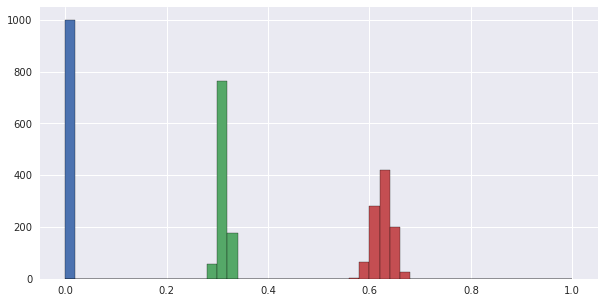

In [5]:
print(sample1.HMM.get_stationary_distribution())

for mean, var in zip(sample1.HMM.means_, sample1.HMM.covars_[:,0]):
    x = np.random.normal(mean, var, 1000)
    plt.hist(x, bins=np.arange(0,1.01,0.02))

Text(0.5, 1.0, 'Pre Transformation Read Count Per Bin Distribution')

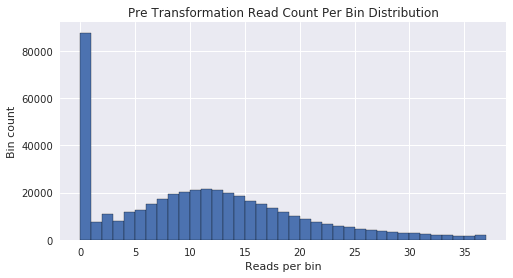

In [9]:
plt.figure(figsize=(8,4))
sample1._raw_data.val.hist(bins=np.arange(sample1._raw_data.val.max()), label='Read count')
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('Pre Transformation Read Count Per Bin Distribution')

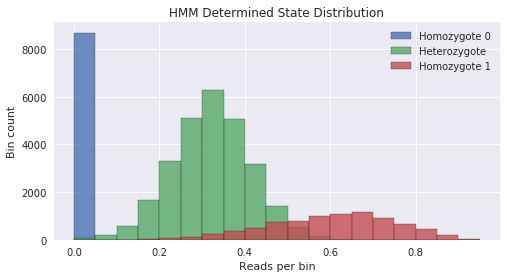

In [10]:
plt.figure(figsize=(8,4))
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('HMM Determined State Distribution')

for pred, name in enumerate(['Homozygote 0', 'Heterozygote', 'Homozygote 1']):
    sample1._data_predictions[sample1._data_predictions.pred == pred].val.hist(bins=np.arange(0,1,0.05),
                                                                                   alpha=0.8, label=name)
plt.legend()

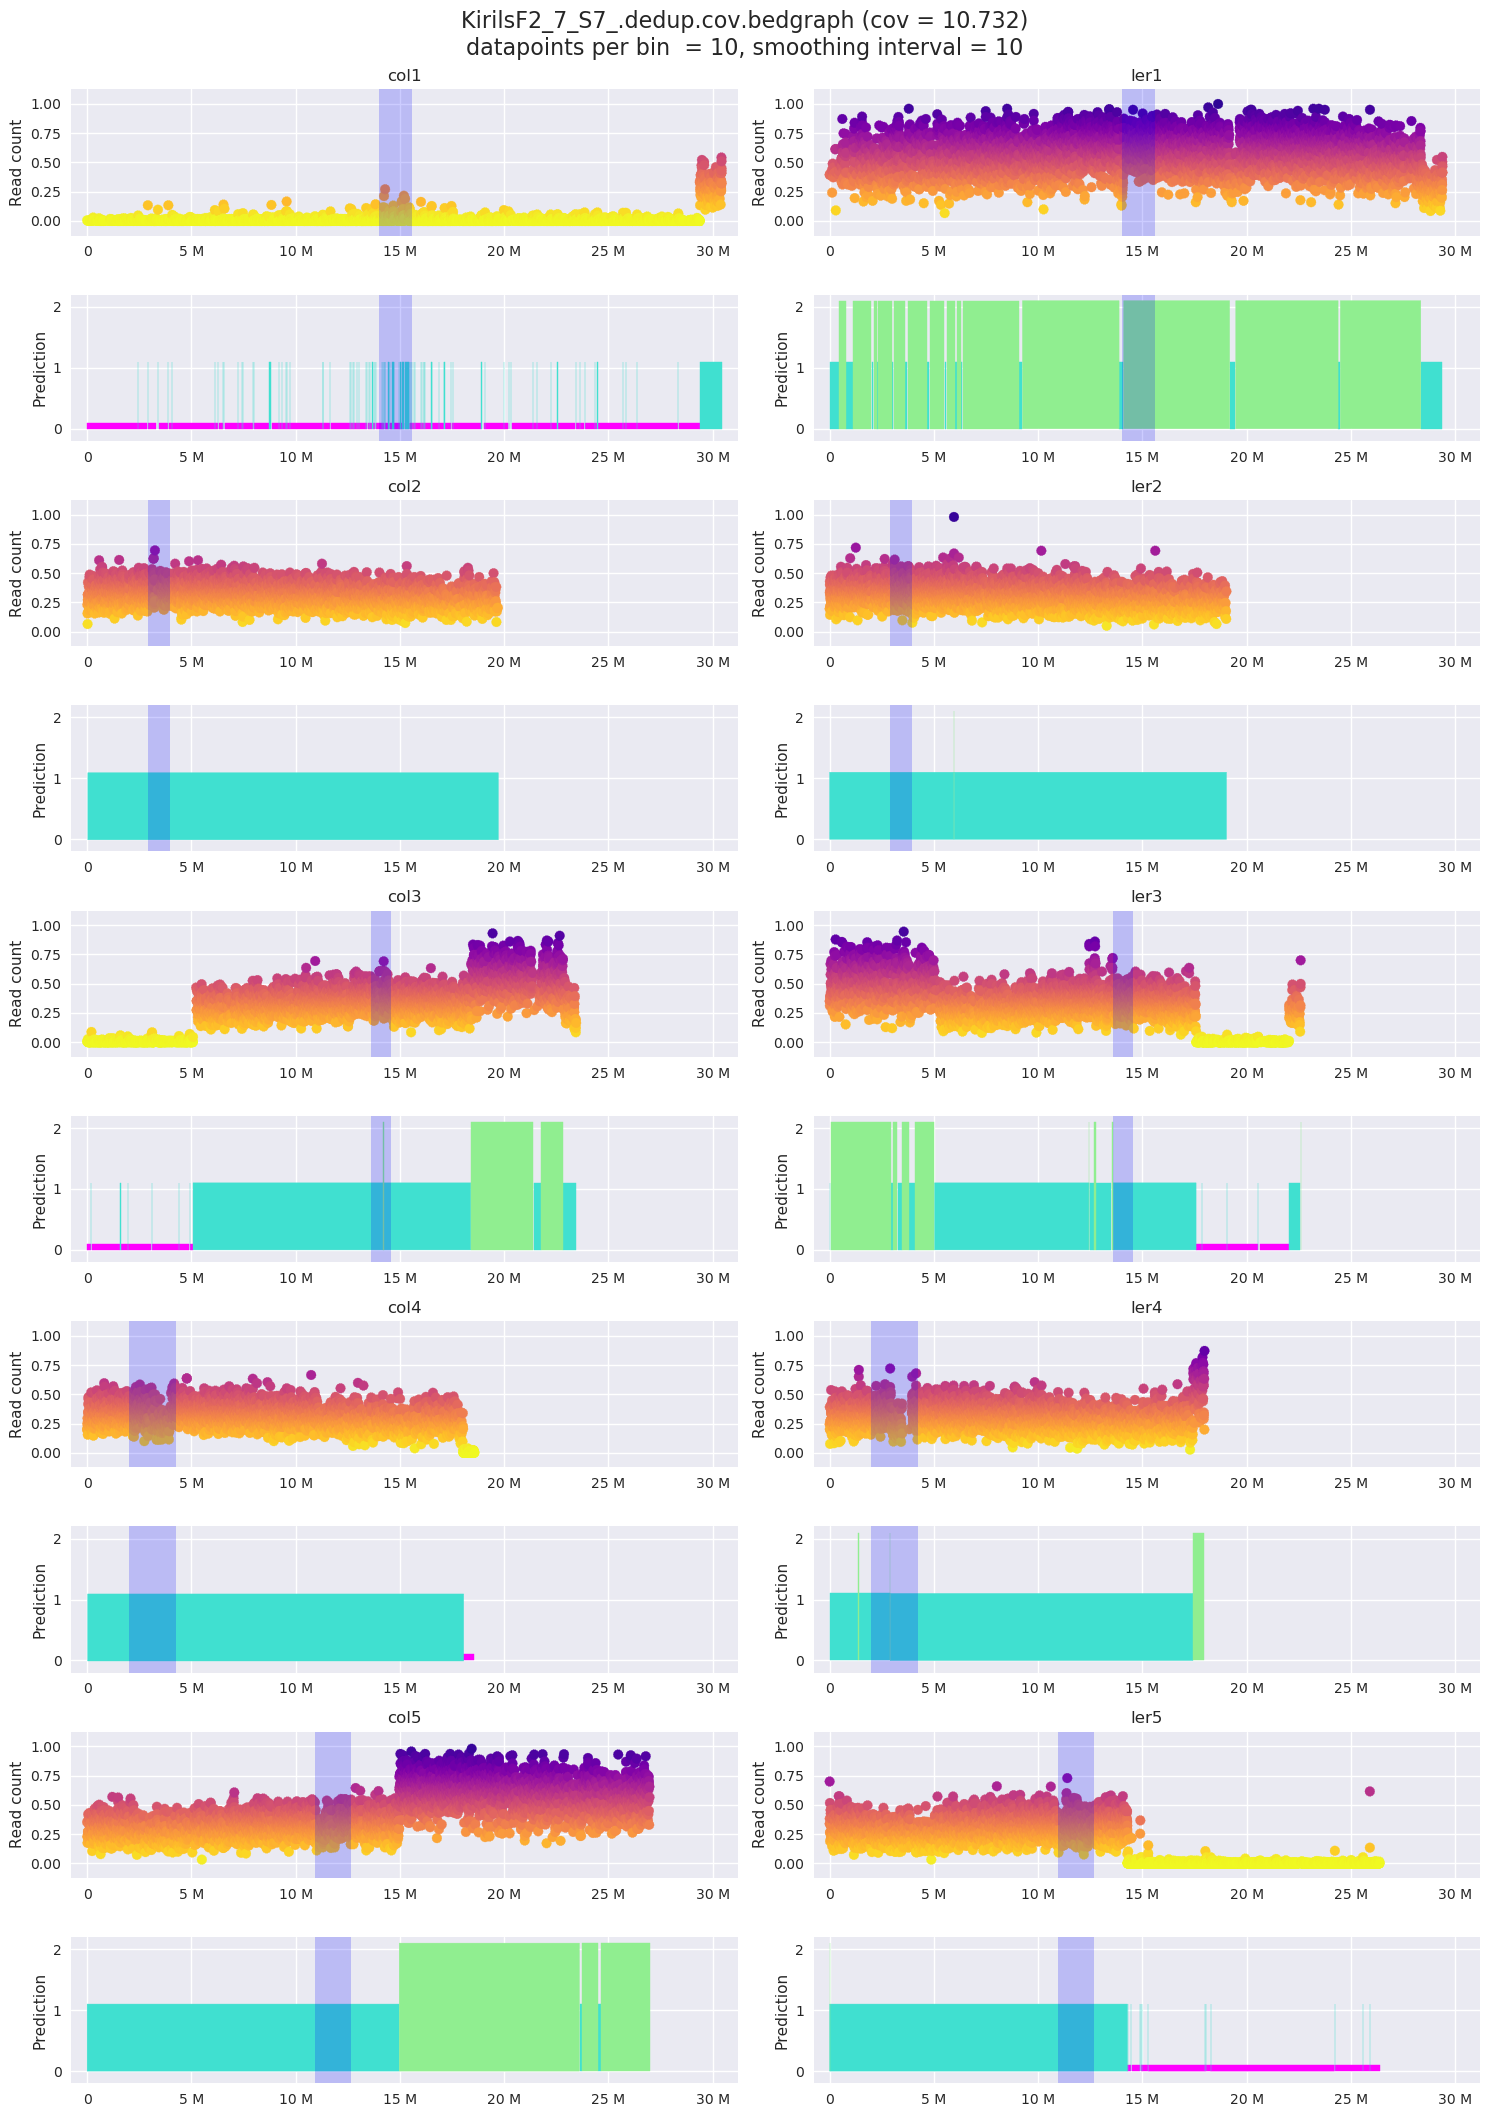

In [11]:
sample1.plot_hmm(val_column='pred')

In [12]:
sample1.crossovers

,chrm,start,end,val,pred,probs,smooth,updated,change,abs_pos,pos_ler,dist,possible_dup,binsize,binsize_percentile,context
5071,col1,29377401,29381001,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,0.9656,28350001,0.0009,False,3600,56.66,NaN
9632,col3,5068201,5077801,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,0.2165,5028601,0.0061,False,9600,91.05,NaN
12763,col3,18397201,18411801,0.2187,1,"[0.0, 0.991, 0.009]",-1,1,2,0.7849,17583601,0.0065,False,14600,96.65,NaN
13317,col3,22814601,22819001,0.7143,2,"[0.0, 0.0, 1.0]",-1,2,1,0.9728,22034201,0.0027,False,4400,66.69,NaN
16872,col4,18031201,18036201,0.2041,1,"[0.0, 1.0, 0.0]",-1,1,0,0.9705,17426801,0.0013,False,5000,71.04,NaN
19813,col5,14959801,14964601,0.2945,1,"[0.0, 0.974, 0.026]",-1,1,2,0.5547,14323801,0.0116,False,4800,68.86,NaN


## Testing

In [10]:
def get_source(suspect_idx):
    sus_bin = sample1._data_predictions.iloc[suspect_idx-2:suspect_idx+2, :3]
    res =  sample1._raw_data[(sample1._raw_data.chrm == sus_bin.iloc[0].chrm) &
                               (sample1._raw_data.start >= sus_bin.iloc[0].start) &
                               (sample1._raw_data.end <= sus_bin.iloc[-1].end)]
    local_max = res.val.idxmax()
    print(sample1._raw_data.loc[local_max])
    return res

In [19]:
shdema_results = pd.read_csv('Kiril_co_table.csv', usecols=[2, 3, 5, 6, 13])
shdema_results.rename(columns={'chr':'chrm'}, inplace=True)
shdema_results.dropna(how='all', inplace=True)
shdema_results = shdema_results

def res_shdema(n):
    return shdema_results[shdema_results.plant == 'kiril_F2_{}'.format(n)]

def shdema_diff(n, droplabels=False):
    df = res_shdema(n)
    co_copy = sample1.crossovers.copy()
    co_copy = co_copy.reset_index()
    merge = df.merge(co_copy, on=['chrm', 'updated', 'change'], how='outer', sort=True)
    merge['diff'] = (merge['average_snp_co'].astype(float) - merge['end']).abs()
    if droplabels:
        merge.drop(droplabels, inplace=True)
    print(merge['diff'].describe().round(1))
    merge = merge.sort_values(by=['index'])
    return merge.drop(columns=['abs_pos','dist','smooth'])

In [20]:
shdema_diff(7)

count         6.0
mean      38180.5
std       56514.9
min         520.0
25%        1107.2
50%        2819.5
75%       81078.2
max      115223.0
Name: diff, dtype: float64


,plant,chrm,updated,change,average_snp_co,index,start,end,val,pred,probs,pos_ler,possible_dup,binsize,binsize_percentile,context,diff
0,kiril_F2_7,col1,0.0,1.0,29381521,5071,29377401,29381001,0.0000,0,"[1.0, 0.0, 0.0]",28350001,False,3600,56.66,NaN,520.0
1,kiril_F2_7,col3,0.0,1.0,5193024,9632,5068201,5077801,0.0000,0,"[1.0, 0.0, 0.0]",5028601,False,9600,91.05,NaN,115223.0
2,kiril_F2_7,col3,1.0,2.0,18409862,12763,18397201,18411801,0.2187,1,"[0.0, 0.991, 0.009]",17583601,False,14600,96.65,NaN,1939.0
3,kiril_F2_7,col3,2.0,1.0,22925872,13317,22814601,22819001,0.7143,2,"[0.0, 0.0, 1.0]",22034201,False,4400,66.69,NaN,106871.0
4,kiril_F2_7,col4,1.0,0.0,18035371,16872,18031201,18036201,0.2041,1,"[0.0, 1.0, 0.0]",17426801,False,5000,71.04,NaN,830.0
5,kiril_F2_7,col5,1.0,2.0,14960901,19813,14959801,14964601,0.2945,1,"[0.0, 0.974, 0.026]",14323801,False,4800,68.86,NaN,3700.0


In [21]:
sample1._data_predictions.loc[9630:9635]

,chrm,start,end,val,pred,probs,smooth,updated
9630,col3,5050801,5061601,0.002915,0,"[1.0, 0.0, 0.0]",-1,0
9631,col3,5061601,5067601,0.002915,0,"[1.0, 0.0, 0.0]",-1,0
9632,col3,5068201,5077801,0.000000,0,"[1.0, 0.0, 0.0]",-1,0
9633,col3,5078401,5228201,0.043732,1,"[0.001, 0.999, 0.0]",-1,1
9634,col3,5228201,5245001,0.466472,1,"[0.0, 1.0, 0.0]",-1,1
9635,col3,5245001,5247801,0.274052,1,"[0.0, 1.0, 0.0]",-1,1


In [22]:
get_source(9633)

chrm        col3
start    5244601
end      5244801
val           24
Name: 96328, dtype: object


,chrm,start,end,val
96290,col3,5061601,5061801,1
96291,col3,5062001,5062201,0
96292,col3,5062201,5062401,0
96293,col3,5065401,5065601,0
96294,col3,5065601,5065801,0
96295,col3,5065801,5066001,0
96296,col3,5066401,5066601,0
96297,col3,5066601,5066801,0
96298,col3,5066801,5067001,0
96299,col3,5067401,5067601,0


In [15]:
temp = get_source(9632)
t_val = temp.val.values / sample1._raw_data.val.max()
temp['pred'] = sample1.HMM.predict(t_val.reshape(-1, 1))
temp

chrm        col3
start    5228001
end      5228201
val            9
Name: 96319, dtype: object


,chrm,start,end,val,pred
96280,col3,5050801,5051001,0,0
96281,col3,5052401,5052601,0,0
96282,col3,5054201,5054401,0,0
96283,col3,5054401,5054601,0,0
96284,col3,5055201,5055401,0,0
96285,col3,5055401,5055601,0,0
96286,col3,5055601,5055801,0,0
96287,col3,5058201,5058401,0,0
96288,col3,5060001,5060201,0,0
96289,col3,5061401,5061601,1,0


In [23]:
sample1.lift_syri('~/datasets/TAIR10/syri_denovo.out', 'col')

/home/labs/alevy/zisserh/proj/crossover_detection/coda.py:417: RuntimeWarning: invalid value encountered in greater_equal
  (((sus_end[:, None] >= syri_start) & (sus_end[:, None] <= syri_end)))) # or bin end in syri region
/home/labs/alevy/zisserh/proj/crossover_detection/coda.py:417: RuntimeWarning: invalid value encountered in less_equal
  (((sus_end[:, None] >= syri_start) & (sus_end[:, None] <= syri_end)))) # or bin end in syri region


,index,chrm,start,end,val,pred,probs,smooth,updated,change,...,a_chr,a_start,a_end,b_chr,b_start,b_end,id,parent_id,ann,cp
0,5071,col1,29377401,29381001,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,...,col1,29380726.0,29470764.0,Chr1,28353658.0,28443991.0,SYN551,NaN,SYN,NaN
1,5071,col1,29377401,29381001,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,...,col1,29380726.0,29470764.0,Chr1,28353658.0,28443991.0,SYNAL1100,SYN551,SYNAL,NaN
2,9632,col3,5068201,5077801,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,...,col3,4922095.0,5379338.0,Chr3,4969186.0,5426919.0,SYN1031,NaN,SYN,NaN
3,9632,col3,5068201,5077801,0.0000,0,"[1.0, 0.0, 0.0]",-1,0,1,...,col3,5025183.0,5202105.0,Chr3,5073724.0,5250684.0,SYNAL2049,SYN1031,SYNAL,NaN
4,12763,col3,18397201,18411801,0.2187,1,"[0.0, 0.991, 0.009]",-1,1,2,...,col3,18242262.0,18503492.0,Chr3,17414339.0,17675070.0,SYN1376,NaN,SYN,NaN
5,12763,col3,18397201,18411801,0.2187,1,"[0.0, 0.991, 0.009]",-1,1,2,...,col3,18358728.0,18503492.0,Chr3,17530218.0,17675070.0,SYNAL2707,SYN1376,SYNAL,NaN
6,13317,col3,22814601,22819001,0.7143,2,"[0.0, 0.0, 1.0]",-1,2,1,...,col3,22771975.0,23004764.0,Chr3,21884285.0,22116695.0,SYN1420,NaN,SYN,NaN
7,13317,col3,22814601,22819001,0.7143,2,"[0.0, 0.0, 1.0]",-1,2,1,...,col3,22771975.0,23004764.0,Chr3,21884285.0,22116695.0,SYNAL2796,SYN1420,SYNAL,NaN
8,16872,col4,18031201,18036201,0.2041,1,"[0.0, 1.0, 0.0]",-1,1,0,...,col4,17952009.0,18189047.0,Chr4,17342658.0,17584466.0,SYN1753,NaN,SYN,NaN
9,16872,col4,18031201,18036201,0.2041,1,"[0.0, 1.0, 0.0]",-1,1,0,...,col4,17952009.0,18087204.0,Chr4,17342658.0,17477776.0,SYNAL3470,SYN1753,SYNAL,NaN
